In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['image.origin']='lower'
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Circle
from matplotlib.animation import FFMpegWriter, PillowWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.html'] = 'html5'
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':'nearest'})

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi
import scoobi.utils as utils

import lina

import time


/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [67]:
time.sleep(10)

In [2]:
# iefc_data = utils.load_pickle(f'../data/llowfsc+iefc/{20241216}_iefc_run_180_1.pkl')
# camsci_data_1 = utils.load_pickle(f'../data/llowfsc+iefc/{20241216}_camsci_stream_1.pkl')
# camsci_data_2 = utils.load_pickle(f'../data/llowfsc+iefc/{20241216}_camsci_stream_2.pkl')

iefc_data = utils.load_pickle(f'../data/llowfsc+iefc/{20241217}_iefc_run_1.pkl')
camsci_data_1 = utils.load_pickle(f'../data/llowfsc+iefc/{20241217}_camsci_stream_1.pkl')
camsci_data_2 = utils.load_pickle(f'../data/llowfsc+iefc/{20241217}_camsci_stream_2.pkl')
camsci_data_3 = utils.load_pickle(f'../data/llowfsc+iefc/{20241217}_camsci_stream_3.pkl')
camsci_data_4 = utils.load_pickle(f'../data/llowfsc+iefc/{20241217}_camsci_stream_4.pkl')
camsci_data_5 = utils.load_pickle(f'../data/llowfsc+iefc/{20241217}_camsci_stream_5.pkl')

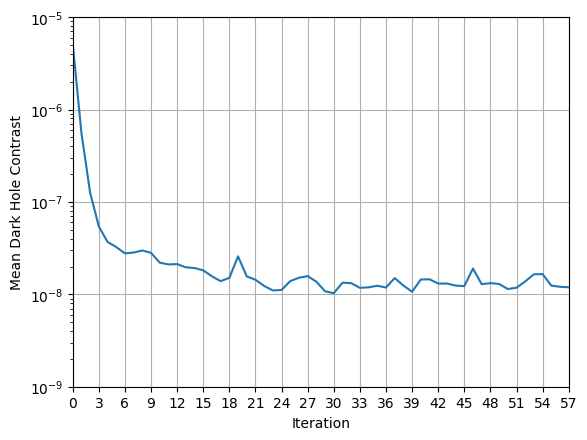

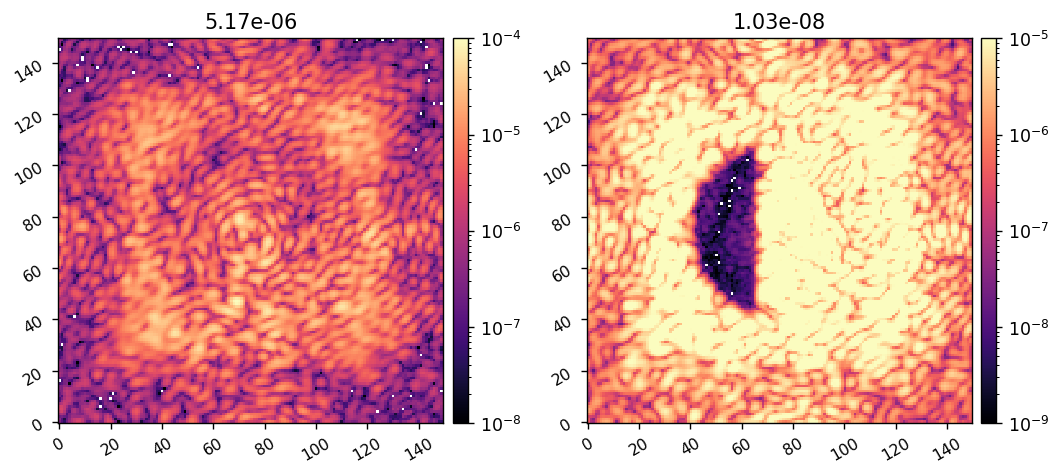

In [4]:
iefc_ims = xp.array(iefc_data['images'])
control_mask = iefc_data['control_mask_2']

iefc_contrasts = xp.mean(iefc_ims[:, control_mask], axis=1)

ref_contrast = iefc_contrasts[0]
ref_im = iefc_ims[0]

best_itr = xp.argmin(iefc_contrasts)
best_contrast = iefc_contrasts[best_itr]
best_im = iefc_ims[best_itr]

itrs = np.linspace(0, iefc_ims.shape[0]-1,  iefc_ims.shape[0])
plt.semilogy(itrs, ensure_np_array(iefc_contrasts))
plt.xticks(itrs[::3])
plt.xlim([0, iefc_ims.shape[0]-1])
plt.ylim([1e-9, 1e-5])
plt.xlabel('Iteration')
plt.ylabel('Mean Dark Hole Contrast')
plt.grid()
plt.show()

imshow2(
    ref_im, best_im, 
    f'{ref_contrast:.2e}', f'{best_contrast:.2e}',
    lognorm=True, 
    vmin1=1e-8, vmin2=1e-9, vmax1=1e-4, vmax2=1e-5,
)



In [20]:
Nims, duration/(camsci_data_4['N_frames_per_im']*camsci_data_4['texp_per_frame'])

(450, 450.0)

In [19]:
camsci_data_4.keys()

dict_keys(['duration', 'control_mask', 'texp_per_frame', 'N_frames_per_im', 'camsci_ims'])

450 450.0


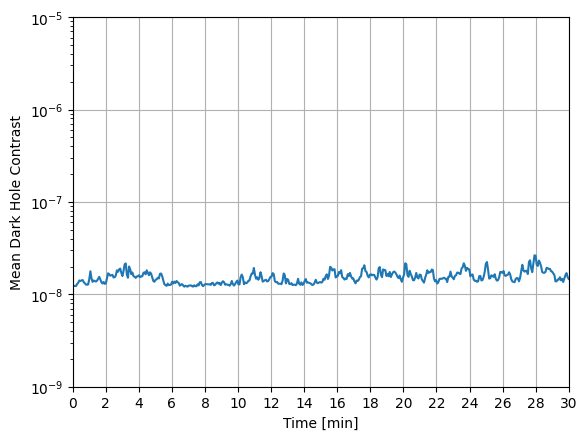

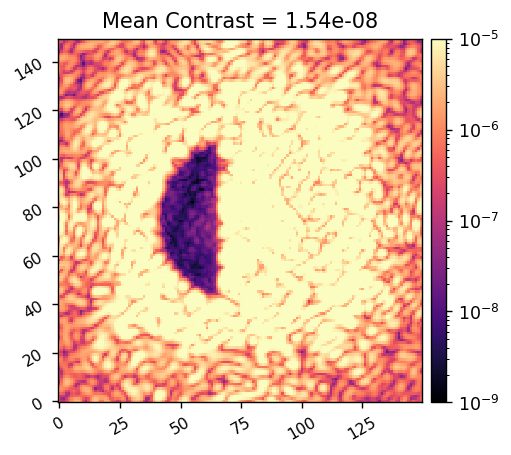

In [24]:
data = camsci_data_4

camsci_ims = data['camsci_ims']
Nims = camsci_ims.shape[0]
mask = data['control_mask']
duration = data['duration']

t_per_im = data['N_frames_per_im']*data['texp_per_frame']
expected_Nims = duration/t_per_im
print(Nims, expected_Nims)

contrasts = xp.mean(camsci_ims[:, mask], axis=1)
times = np.linspace(0, duration/60, Nims)
time_ticks = np.linspace(0, duration/60, 16)

plt.semilogy(times, ensure_np_array(contrasts))
plt.xticks(time_ticks)
plt.xlim([0, duration/60])
plt.ylim([1e-9, 1e-5])
plt.xlabel('Time [min]')
plt.ylabel('Mean Dark Hole Contrast')
plt.grid()
plt.show()

unprobed_ims = camsci_ims[contrasts<5e-8]

mean_im = xp.mean(camsci_ims, axis=0)
# mean_im = xp.mean(unprobed_ims, axis=0)

mean_contrast = xp.mean(mean_im[mask])
imshow1(
    mean_im, 
    f'Mean Contrast = {mean_contrast:.2e}',
    lognorm=True, vmin=1e-9, vmax=1e-5,
)



In [17]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['image.origin']='lower'
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Circle
from matplotlib.animation import FFMpegWriter, PillowWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.html'] = 'html5'
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':'nearest'})

def create_anim(
        data, 
        cmap='magma',
        norm=None,
        extent=None,
        interval=0.25, # in ms
    ):

    ims = ensure_np_array(data['camsci_ims'])
    mask = ensure_np_array(data['control_mask'])
    contrasts = np.mean(ims[:, mask], axis=1)
    Nims = ims.shape[0]
    times = np.linspace(0, data['duration']/60, Nims)

    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5),dpi=125)

    im1 = ax.imshow(ims[0], norm=norm, cmap=cmap, extent=extent)
    im1_title = ax.set_title(f'With LLOWFSC Normalized Image\nTime = {(times[0]):.2f} min\nMean NI = {contrasts[0]:.2e}', fontsize=14)
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="4%", pad=0.075)
    cbar1 = fig.colorbar(im1, cax=cax1)
    ax.add_patch(Circle((0,0), 3, fill=False, color='cyan'))
    ax.add_patch(Circle((0,0), 10, fill=False, color='cyan'))

    def animate(i):
        im1.set_data(ims[i])
        im1_title.set_text(f'With LLOWFSC Normalized Image\nTime = {times[i]:.2f} min\nMean NI = {contrasts[i]:.2e}')

    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=Nims, interval=interval)
    return anim

In [19]:
pxscl = 0.307
npsf = camsci_data_4['camsci_ims'].shape[1]
im_lim = pxscl * npsf/2 
im_extent = [-im_lim, im_lim, -im_lim, im_lim]

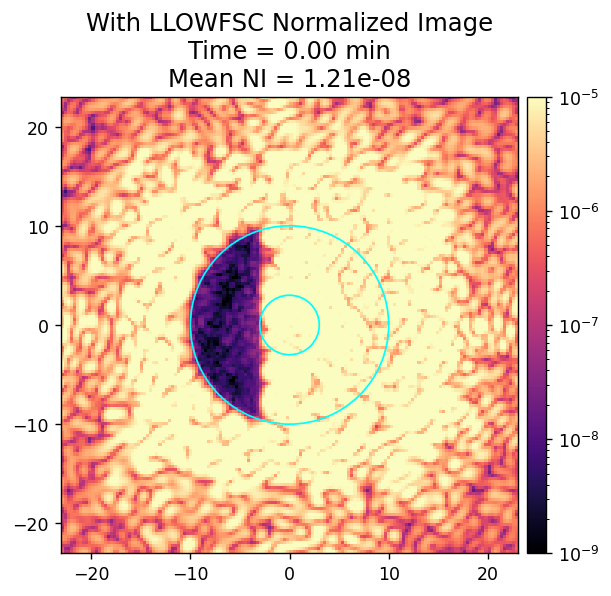

In [20]:
norm = LogNorm(vmin=1e-9, vmax=1e-5, clip=True)

anim = create_anim(
    camsci_data_4, 
    cmap='magma',
    norm=norm,
    extent=im_extent,
    interval=100, # in ms
)

In [21]:
anim

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size in inches has been adjusted from 5.0 x 5.0 to 4.992 x 4.992
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 624x624 -pix_fmt rgba -framerate 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp42jk8wfq/temp.m4v
